In [21]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
df = pd.read_csv('data/x_train.csv')
df2 = pd.read_csv('data/y_train.csv')
x_train = df.copy()
y_train = df2.copy()

filter1 = pd.read_json('filter.json')

In [23]:
# x_train.iloc[:, 14:].head() # Take the filtered features instead
filter1_titles = filter1["title"].tolist()
x_train_f1 = x_train[filter1_titles] # doesn't work
x_train_f1.head()

,CELLFON3,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,BPHIGH4,...,_PA300R2,_PA30021,_PASTRNG,_PAREC1,_LMTACT1,_LMTWRK1,_LMTSCL1,_FLSHOT6,_PNEUMO2,_AIDTST3
0,NaN,2.0,1.0,5,88.0,1,1,2.0,1.0,3.0,...,2,2,1,1,3.0,3.0,4.0,NaN,NaN,2.0
1,1.0,4.0,88.0,88,NaN,1,1,2.0,1.0,1.0,...,9,9,9,9,3.0,3.0,4.0,NaN,NaN,NaN
2,2.0,2.0,77.0,77,88.0,1,1,2.0,1.0,3.0,...,2,2,2,4,2.0,2.0,3.0,1.0,2.0,2.0
3,NaN,1.0,88.0,88,NaN,1,1,2.0,1.0,3.0,...,1,1,2,2,2.0,2.0,3.0,2.0,2.0,2.0
4,1.0,2.0,88.0,88,NaN,1,9,2.0,1.0,3.0,...,9,9,2,9,3.0,3.0,4.0,9.0,9.0,2.0


## Correlation

<Axes: >

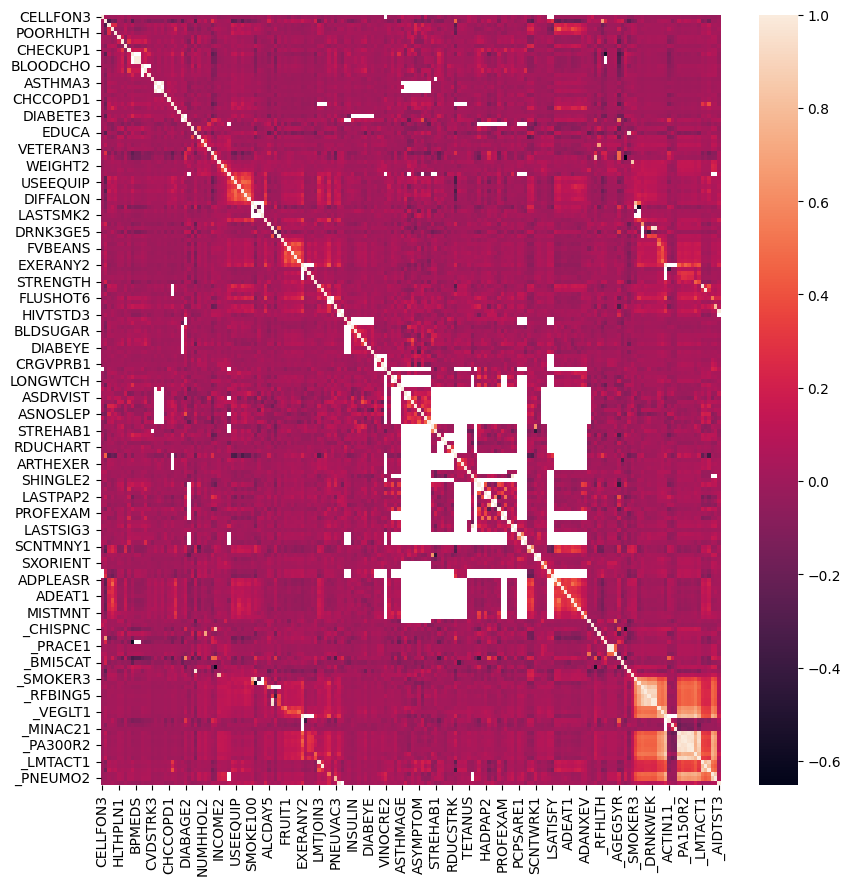

In [24]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(x_train_f1.corr(), fmt='.2f')

# 2nd filter makes a set with the features that are not correlated with each other

/Users/msaillen/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:93: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  func(*args, **kwargs)
/Users/msaillen/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


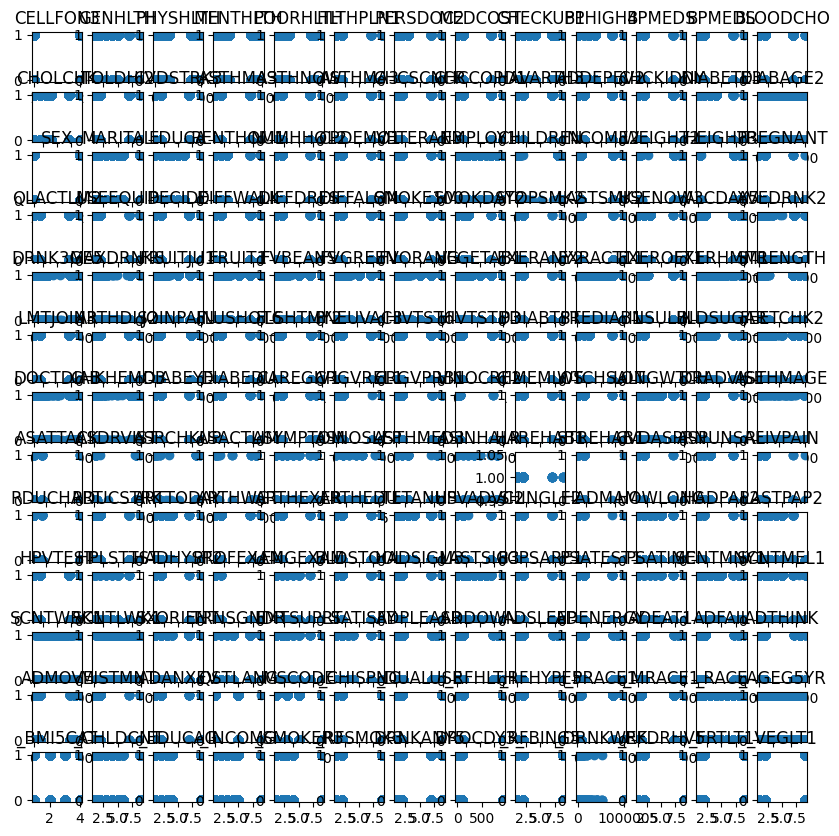

In [27]:
features = x_train_f1.columns
rows, cols = [int(len(features)**0.5)]*2
fig, axes = plt.subplots(rows, cols, figsize=(10, 10), tight_layout=True)
count = 0
for i in range(rows):
    for j in range(cols):
        axes[i, j].scatter(x_train_f1.iloc[:, count], y_train)
        axes[i, j].set_title(features[count])
        count += 1

(0.0, 20000.0)

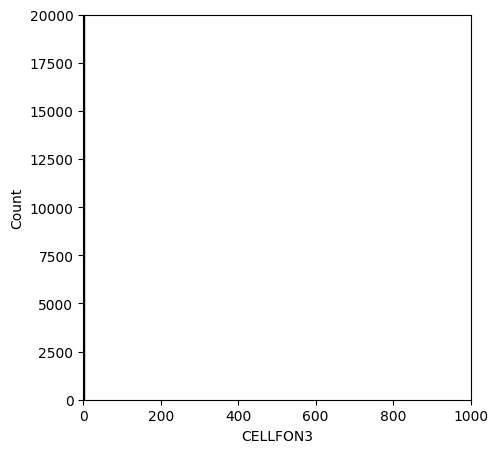

In [28]:
fig = plt.figure(figsize=(5, 5))
sns.histplot(x_train_f1.iloc[:, 0])
plt.xlim(0, 1000)
plt.ylim(0, 20000)

## Train the model

In [36]:
from implementations import least_squares, ridge_regression

# All rows contain NaN values => Dropping them all would result in an empty dataset
# x_train_c = x_train_f1.dropna() # x_train cleaned by dropping all rows containing NaN value(s)
# Instead, let's replace NaN values by the mean of the column
x_train_c = x_train_f1.fillna(x_train_f1.mean())
print(x_train_c.values)

weights, mse = least_squares(y_train.values, x_train_c.values)
print("Weights: " + str(weights) + "\nMSE: " + str(mse))

[[ 1.54463226  2.          1.         ...  2.28990981  2.4067936
   2.        ]
 [ 1.          4.         88.         ...  2.28990981  2.4067936
   1.96667511]
 [ 2.          2.         77.         ...  1.          2.
   2.        ]
 ...
 [ 1.          3.         88.         ...  2.          2.
   2.        ]
 [ 1.          3.         88.         ...  2.28990981  2.4067936
   2.        ]
 [ 2.          2.          7.         ...  2.28990981  2.4067936
   2.        ]]
Weights: [[-1.88720444e-02]
 [ 1.60770643e-02]
 [-4.99058968e-04]
 [ 5.34512323e-04]
 [ 2.13808805e-04]
 [ 6.59106016e-02]
 [-5.04045447e-02]
 [-1.12418684e-01]
 [-1.67249768e-03]
 [-3.06642227e-02]
 [-9.25335232e+14]
 [ 9.25335232e+14]
 [-1.07980737e-02]
 [-4.90687824e-03]
 [-1.01725013e-02]
 [-9.94500987e-02]
 [-2.09088668e+14]
 [-2.28118013e-03]
 [ 2.09088668e+14]
 [-9.72995725e-03]
 [-2.27096194e-02]
 [-6.36653094e-03]
 [-5.38231193e-04]
 [-2.03939550e-02]
 [-2.43069620e-02]
 [ 2.71802537e-04]
 [-4.71413241e-02]
 [-9.6

/Users/msaillen/Desktop/labs/ml_project1/implementations.py:25: RuntimeWarning: invalid value encountered in matmul
  w = np.linalg.solve(tx.T@tx, tx.T@y)


## Make predictions

In [40]:
# Now, we can use the weights to predict which columns correlate the most with y_train

y_pred = x_train_c.values.dot(weights)
print("y_pred: " + str(y_pred))

# Let's transform the predictions with values from 0 to 1

y_pred_norm = (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())

# If the value is above 0.5, we consider it to be 1, otherwise 0

y_pred_norm[y_pred_norm > 0.5] = 1
y_pred_norm[y_pred_norm <= 0.5] = 0

# Let's store the predictions in a submission_file.csv in CSV format without index_label

submission_file = pd.DataFrame(y_pred_norm, columns=["_MICHD"])
submission_file.to_csv('submission_file.csv', index=False)





y_pred: [[-0.06025164]
 [ 0.10454032]
 [-0.00626197]
 ...
 [ 0.07788804]
 [-0.05314675]
 [ 0.28530579]]
